In [71]:
import matplotlib.pylab as plt

plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")

In [72]:
# load file
import numpy as np
# f = np.load("./model_maxtime_combine_jobs_DSNB_sk_data/predict_0.npz", allow_pickle=True)
f = np.load("/afs/ihep.ac.cn/users/l/luoxj/sk_psd/model_maxtime_time_jobs_DSNB_sk_data/predict_0.npz", allow_pickle=True)
print(f"key: {f.files}")
predict_proba = f["predict_proba"][:,1]
equen = f["equen"]
vertex = f["vertex"]
labels = f["labels"]
pdgs = f["pdg_bkg"]
# print("predict_proba: ", predict_proba)
# print("labels: ", labels)
# print("pdg:  ", pdgs)

key: ['predict_proba', 'equen', 'vertex', 'labels', 'pdg_bkg']


In [73]:
# seperate sig and bkg
dir_proba ={}
dir_vertex = {}
dir_equen = {}
dir_proba["sig"] = predict_proba[labels==1]
dir_proba["bkg"] = predict_proba[labels==0]
dir_vertex["sig"] = vertex[labels==1]
dir_vertex["bkg"] = vertex[labels==0]
dir_equen["sig"] = equen[labels==1]
dir_equen["bkg"] = equen[labels==0]

# print("Check bkg length: ")
# print("proba->  ", len(dir_proba["bkg"]))
# print("pdg-> ", len(pdgs))
# print("vertex-> ", len(dir_vertex["bkg"]))

In [74]:
# Study pdgs
from collections import Counter
def GetNucleiNum(pdg_evt):
    n_nuclei = 0
    counter = Counter(pdg_evt)
    for key in counter:
        if key > 1000000000:
            n_nuclei += counter[key]
    return n_nuclei

def PdgToN(Nuclei_pdg):
    N = int(Nuclei_pdg/10)%1000
    Z = int(Nuclei_pdg/10000)%1000
    return (N, Z)

class OneNucleiEvts:
    def __init__(self):
        self.probs = []
        self.v_NZ = []
    def Print(self):
        print(f"probs: {self.probs}")
        print(f"v_NZ: {self.v_NZ}")
evt_1Nuclei = OneNucleiEvts()

v_pdg_multi_nuclei = []
v_proba_multi_nuclei = []
for i, pdg_evt in enumerate(pdgs):
    n_nuclei = GetNucleiNum(pdg_evt)
    if n_nuclei == 1 :
        Nuclei_pdg = pdg_evt[pdg_evt>1000000000][0]
        (N, Z ) = PdgToN(Nuclei_pdg)
        evt_1Nuclei.probs.append(dir_proba["bkg"][i])
        evt_1Nuclei.v_NZ.append([N,Z])
    else:
        v_proba_multi_nuclei.append(dir_proba["bkg"][i] )
        v_pdg_multi_nuclei.append(pdg_evt)
# evt_1Nuclei.Print()


## Find The Right Criteria

In [75]:
criteria_to_use = 0
for criteria in np.arange(0.9, 1, 0.005 ):
    print("Criteria :\t", criteria)
    index_bkg_rightPredict = (dir_proba["bkg"]<criteria)
    counter_bkglike = Counter(index_bkg_rightPredict)
    eff_bkg = counter_bkglike[True]/len(index_bkg_rightPredict)
    print("Efficiency of bkg:\t", eff_bkg)

    index_sig_rightPredict = (dir_proba["sig"]>criteria)
    counter_sig_rightPredict = Counter(index_sig_rightPredict)
    eff_sig = counter_sig_rightPredict[True]/len(index_sig_rightPredict)
    print("Efficiency of sig:\t", eff_sig)
    if eff_bkg > 0.99:
        criteria_to_use = criteria
        break
    print("###########################################")
print("Will use criteria --> ", criteria_to_use)

Criteria :	 0.9
Efficiency of bkg:	 0.985035822150111
Efficiency of sig:	 0.9249054353881792
###########################################
Criteria :	 0.905
Efficiency of bkg:	 0.9855636246346923
Efficiency of sig:	 0.9203995660290683
###########################################
Criteria :	 0.91
Efficiency of bkg:	 0.9858959447175768
Efficiency of sig:	 0.915238830624273
###########################################
Criteria :	 0.915
Efficiency of bkg:	 0.9863651024816491
Efficiency of sig:	 0.9097457751365934
###########################################
Criteria :	 0.92
Efficiency of bkg:	 0.9868147120055517
Efficiency of sig:	 0.9035196606425506
###########################################
Criteria :	 0.925
Efficiency of bkg:	 0.9873522886102178
Efficiency of sig:	 0.8961890705789212
###########################################
Criteria :	 0.93
Efficiency of bkg:	 0.9880364770161566
Efficiency of sig:	 0.8880570026683348
###########################################
Criteria :	 0.935
Efficienc

## Check $^{11}C$ and $^{10}B$ Background (Signal like ratio)


In [76]:
def HistTimes(hist:np.ndarray, times:int):
    hist_return = list(hist)*times
    return np.array(hist_return)

<ipython-input-77-3e8c9ff070c9>:30: RuntimeWarning: invalid value encountered in true_divide
  h_ratio = np.nan_to_num(np.array(h_siglike)/((np.array(h_bkglike))+np.array(h_siglike)))


Text(0.5, 1.0, 'Ratio(Sig-like/Total)')

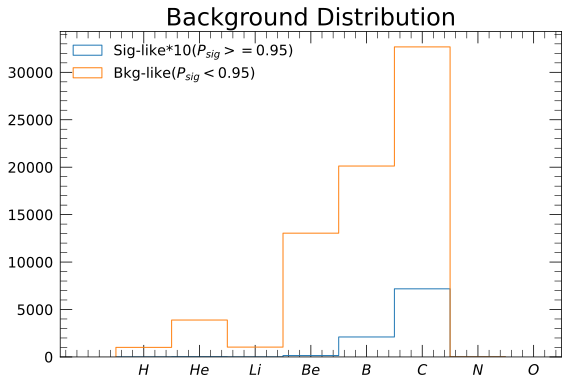

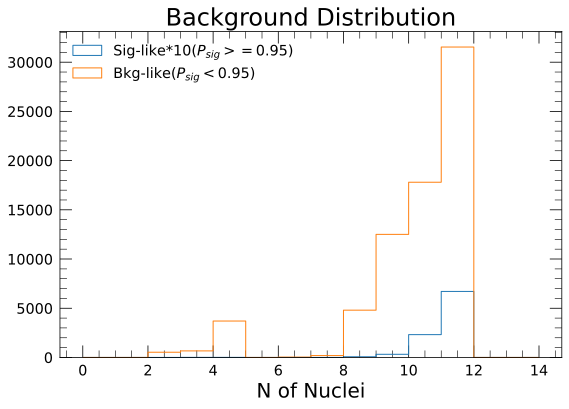

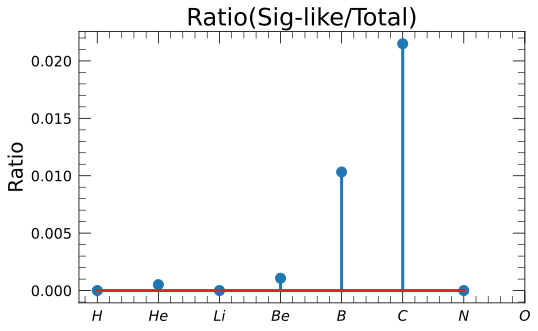

In [77]:
## Draw Nuclei distribution
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pylab as plt
criteria = criteria_to_use
index_siglike = (np.array(evt_1Nuclei.probs)>=criteria)
index_bkglike = (np.array(evt_1Nuclei.probs)<criteria)

labels = ["$H$", "$He$", "$Li$", "$Be$", "$B$", "$C$", "$N$", "$O$"]
plt.figure(figsize=(9, 6))
x =np.arange(1, len(labels)+1)
h_siglike = plt.hist(HistTimes(np.array(evt_1Nuclei.v_NZ)[index_siglike][:,1],10), bins=x , histtype='step', label="Sig-like*10($P_{sig}>=$"+"{:.2f}".format(criteria)+")")
h_bkglike = plt.hist(np.array(evt_1Nuclei.v_NZ)[index_bkglike][:,1], bins=x, histtype='step', label="Bkg-like($P_{sig}"+"<${:.2f}".format(criteria)+")")
plt.title("Background Distribution")
plt.xticks(x+0.5, labels)
plt.xlim([0, len(labels)+1])
# plt.xlabel("Z of Proton")
plt.legend(loc="upper left")

plt.figure(figsize=(9, 6))
plt.hist(HistTimes(np.array(evt_1Nuclei.v_NZ)[index_siglike][:,0],10), bins=range(0, 15), histtype='step', label="Sig-like*10($P_{sig}>=$"+"{:.2f}".format(criteria)+")")
plt.hist(np.array(evt_1Nuclei.v_NZ)[index_bkglike][:,0], bins=range(0, 15), histtype='step', label="Bkg-like($P_{sig}"+"<${:.2f}".format(criteria)+")")
plt.title("Background Distribution")
plt.xlabel("N of Nuclei")
plt.legend(loc="upper left")

plt.figure(figsize=(8, 5))
h_siglike = np.array(h_siglike[0])/10
h_bkglike = h_bkglike[0]
h_ratio = np.nan_to_num(np.array(h_siglike)/((np.array(h_bkglike))+np.array(h_siglike)))
plt.stem(h_ratio)
# plt.xlabel("Z of Proton")
plt.xticks(x-1, labels)
plt.ylabel("Ratio")
plt.title("Ratio(Sig-like/Total)")

# plt.show()

In [78]:
print(h_siglike)
print(h_bkglike)

#handle multi-nuclei evt
# print(v_pdg_multi_nuclei, v_proba_multi_nuclei)
print(f"Total multi-nuclei : {len(v_proba_multi_nuclei)}")
v_proba_multi_nuclei = np.array(v_proba_multi_nuclei)
print(f"sig like : {len(v_proba_multi_nuclei[np.array(v_proba_multi_nuclei)>=criteria])}" )
print(f"bkg like : {len(v_proba_multi_nuclei[np.array(v_proba_multi_nuclei)<criteria])}" )
n_siglike_multi_nuclei = len(v_proba_multi_nuclei[np.array(v_proba_multi_nuclei)>=criteria])
n_bkglike_multi_nuclei = len(v_proba_multi_nuclei[np.array(v_proba_multi_nuclei)<criteria])
h_bkglike = np.append(h_bkglike, [n_bkglike_multi_nuclei])
h_siglike = np.append(h_siglike, [n_siglike_multi_nuclei])

[  0.   2.   0.  14. 210. 718.   0.]
[ 1008.  3886.  1034. 13045. 20121. 32682.     0.]
Total multi-nuclei : 29591
sig like : 26
bkg like : 29565


In [79]:
print(h_siglike, h_bkglike)

import pandas as pd

index_C11 = np.where(np.array(labels)=="$C$")[0][0]
pd.DataFrame([np.array(h_bkglike , dtype=np.int),np.array(h_siglike, dtype=np.int)], index=["Background Like", "Signal Like"], columns=labels[:-1]+["Multi-nuclei"])

[  0.   2.   0.  14. 210. 718.   0.  26.] [ 1008.  3886.  1034. 13045. 20121. 32682.     0. 29565.]


,$H$,$He$,$Li$,$Be$,$B$,$C$,$N$,Multi-nuclei
Background Like,1008,3886,1034,13045,20121,32682,0,29565
Signal Like,0,2,0,14,210,718,0,26


In [80]:
print(h_siglike)
print(h_bkglike)
total_evts = np.sum(h_siglike)+np.sum(h_bkglike)
h_bkglike_ratio_to_total = h_bkglike/total_evts
h_siglike_ratio_to_total = h_siglike/total_evts
table = pd.DataFrame([np.array(h_bkglike_ratio_to_total , dtype=np.float),np.array(h_siglike_ratio_to_total, dtype=np.float)], index=["Background Like", "Signal Like"], columns=labels[:-1]+["Multi-nuclei"])

[  0.   2.   0.  14. 210. 718.   0.  26.]
[ 1008.  3886.  1034. 13045. 20121. 32682.     0. 29565.]


In [81]:
ratio_C11 = [ h_siglike_ratio_to_total[index_C11], h_bkglike_ratio_to_total[index_C11]]
ratio_noC11 = [np.sum(h_siglike_ratio_to_total)-h_siglike_ratio_to_total[index_C11], np.sum(h_bkglike_ratio_to_total)-h_bkglike_ratio_to_total[index_C11]]
pd.DataFrame(np.array([ratio_C11, ratio_noC11]).T, columns=["C11", "no-C11"], index=["Signal Like", "Background Like"])









,C11,no-C11
Signal Like,0.007018,0.002463
Background Like,0.319438,0.671081
